#### Bibliotecas

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import osmnx as ox
import networkx as nx
from itertools import combinations
import os
import re
import rasterio
from rasterio.mask import mask
import shutil
import zipfile
from pathlib import Path
from pyproj import Transformer
import multiprocessing as mp
import itertools
import time
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns

print(f'Utilizando a versão {ox.__version__} do OSMNX')

print(f'Eu tenho {mp.cpu_count()} CPUs disponíveis')

Utilizando a versão 2.0.1 do OSMNX
Eu tenho 8 CPUs disponíveis


#### Parâmetros e variáveis

In [2]:
# Caminhos e arquivo de entrada
input_zip_file = r'/Volumes/Dados_na_nuvem/Marcelo/Mestrado PTR/pct1_h_files.zip'
output_folder = r'/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/9_Dissertação/Resultados'
pesquisa_OD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp'
my_crs = '4326' # Verificar em EPSG.io um projeção que te dê o resultado em metros

# Parâmetros
pacote_num = 1          # Número do pacote a ser criado
bacia_nome = "Aricanduva"  # Nome da bacia
verbose = True

# Diretórios e configurações
pacote_path = os.path.join(output_folder, f"Pacote_{pacote_num:02d}")
raw_path = os.path.join(pacote_path, "Raw")
bacias_path = os.path.join(pacote_path, "Bacias", bacia_nome)
clipado_path = os.path.join(bacias_path, "Clipado") # Diretório para salvar os arquivos clipados

# Determinar os pixels acima do threshold
threshold = 70  # Valor informado em milímetros, mas convertido para metros, em função do raster. Valor obtido a partir da IC do Rodrigo.
threshold_max = 300 # Valor obtido a partir do paper da Pregnolato. Novamente, valor informado em milímetros, mas convertido para metros.

# Carregar a planilha no DataFrame
arquivo_matrizOD = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Pesquisa OD 2017/OD-2017/Tabelas-OD2017/Tab25_OD2017.xlsx'
# Considerando que a primeira linha contém os cabeçalhos e as zonas começam de 1
matriz_od_25 = pd.read_excel(arquivo_matrizOD, header=7, index_col=0)
# Exibir as primeiras linhas do DataFrame para verificação
#print(matriz_od_25.head())

#### Escolher qual rede será carregada

In [ ]:
# Neste ponto é possível escolher se a rede a ser carregada será a rede simplificada 
# (somente com os níveis hierárquicos superiores) ou a rede completa, limitada somente pelo bounding box.
rede_completa = True

# Obter o grafo da rede de ruas aplicando o filtro personalizado
# Detalhes em https://wiki.openstreetmap.org/wiki/Highway:International_equivalence

if rede_completa:
    if isinstance(bounding_box_baseline, gpd.GeoDataFrame):
        bounding_box_baseline = bounding_box_baseline.geometry.iloc[0]  # Pega a primeira geometria

    try:
        G_baseline = ox.graph_from_polygon(bounding_box_baseline, network_type='drive')
        print("Grafo obtido com sucesso!")
        G_baseline = ox.routing.add_edge_speeds(G_baseline, fallback=50)  # Adiciona a velocidade dos eixos (km/h) ao grafo como o atributo do eixo speed_kph

    except:
        print(f"Erro ao obter o grafo!")
else:
    # Carregar o grafo de um arquivo GraphML e o bounding box
    try:
        G_baseline = ox.load_graphml(filepath='network_baseline_vel_updated.graphml')
        print('Grafo carregado com sucesso!')
    except:
        print('Arquivo não encontrado')

    try:
        bounding_box_baseline = gpd.read_file('bounding_box_bacia.json')
        print('Bounding box carregado com sucesso!')
    except:
        print('Bounding box não encontrado')

In [3]:
node_baseline, edges_baseline = ox.graph_to_gdfs(G_baseline)

ox.plot_graph(G_baseline)

# Verificar o CRS atual
print("CRS atual do edges_baseline:", edges_baseline.crs)

# Reprojetar para EPSG:31983
edges_baseline_reprojected = edges_baseline.to_crs(epsg=31983)

# Verificar se a reprojeção foi bem-sucedida
print("CRS do edges_baseline_reprojected:", edges_baseline_reprojected.crs)

Grafo carregado com sucesso!
Bounding box carregado com sucesso!


#### Carregar os pontos OD referente a bacia

(65, 3)
EPSG:32723


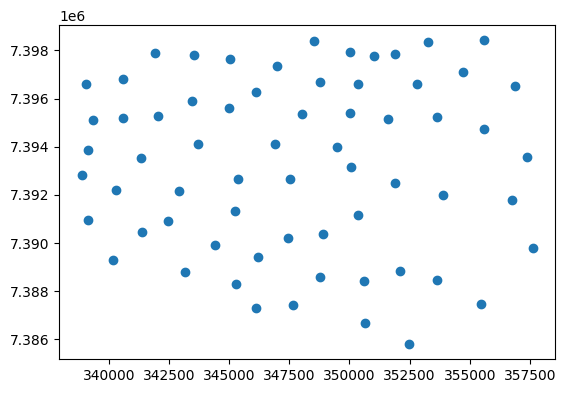

In [4]:
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer

# Read the shapefile
gdf_OD = gpd.read_file(pesquisa_OD)

# You need to understand Geographic coordinate systems and Projected coordinate systems.
# Geographic CRS(such as 'EPSG:4326') is not suitable for measuring distance. 
# Converting degree to distance requires additional work. 
# Use a different coordinate as the warning message shows. 
# The coordinates you usually use depend on the area you want to analyze.
# It will be common to use a coordinate system based on UTM.
    
# Verifica o sistema de coordenadas
gdf_OD.crs

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:32723")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_OD_utm = gdf_OD.to_crs(utm_crs)

# Filtrando para o munícipio de São Paulo
gdf_OD_SP_utm = gdf_OD_utm[gdf_OD_utm['NomeMunici'] == 'São Paulo'].copy()

# Obtendo os centroides
gdf_OD_SP_utm["centroid"] = gdf_OD_SP_utm["geometry"].centroid

if verbose:
    mapa_centroides = gdf_OD_SP_utm['centroid'].explore()
    mapa_centroides.save('mapa_centroides_SP.html')

# Atribuição do esquema de projeção
bounding_box_baseline_utm = bounding_box_baseline.to_crs(utm_crs)

centroides_df = gpd.GeoDataFrame(gdf_OD_SP_utm[['NumeroZona', 'NomeZona']], geometry=gdf_OD_SP_utm['centroid'])
centroides_dentro = gpd.sjoin(centroides_df, bounding_box_baseline_utm, how='inner', predicate='within')

# Remover a coluna de índice criada pelo sjoin
centroides_dentro = centroides_dentro.drop(columns=['index_right'])

# Redefinir o índice
centroides_dentro = centroides_dentro.reset_index(drop=True)

if verbose:
    print(centroides_dentro.shape)
    print(centroides_dentro.crs)
    centroides_dentro.plot()

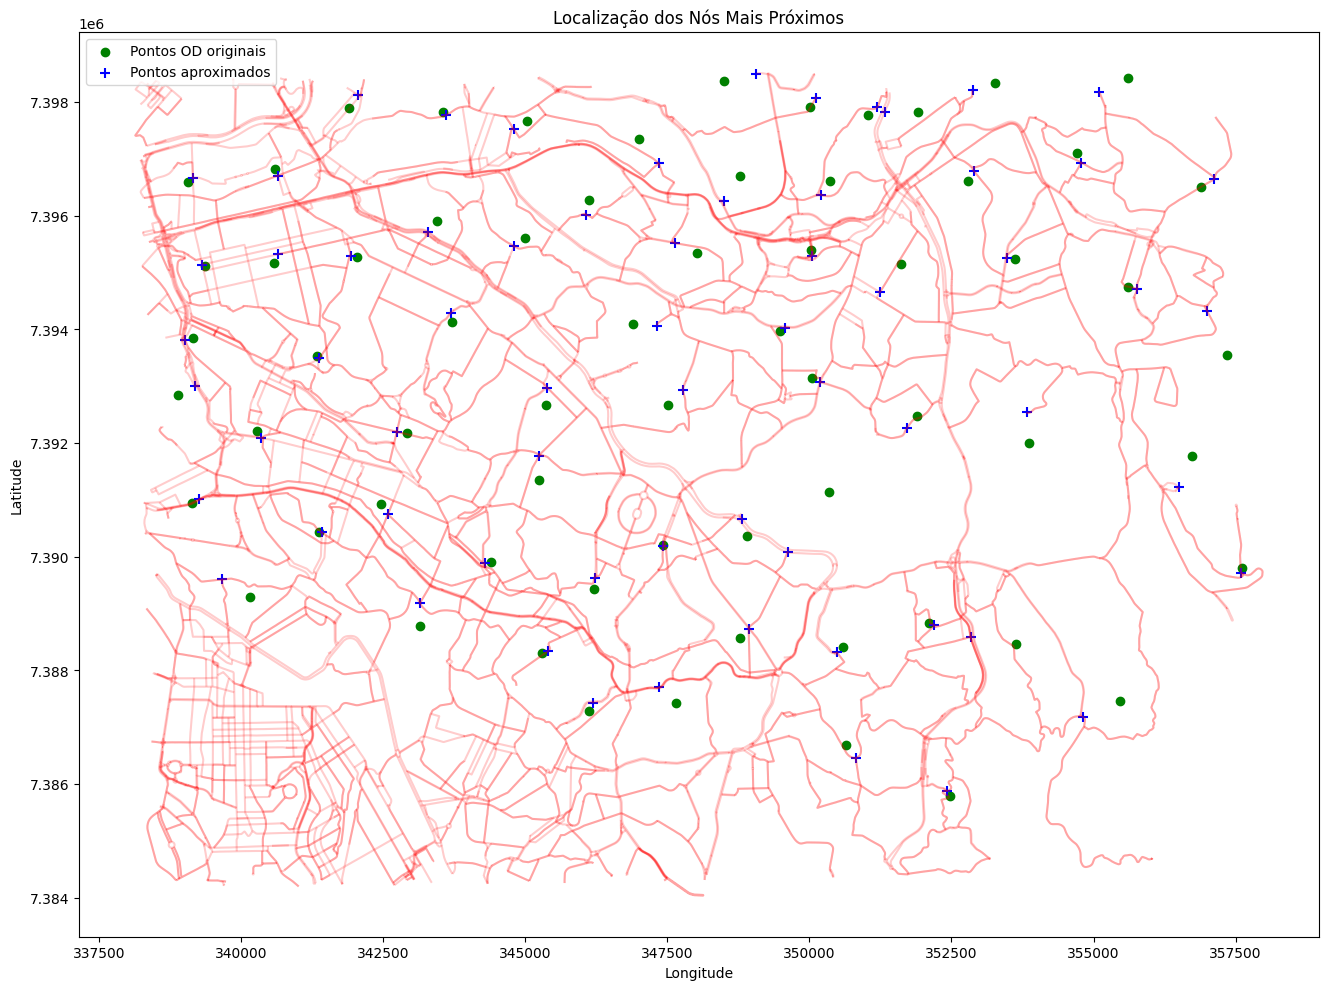

In [7]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Projetar o grafo para o sistema de coordenadas UTM
G_baseline_utm = ox.project_graph(G_baseline, to_crs='EPSG:32723')

# Aproximar os pontos de centroides_dentro à rede
centroides_dentro['nearest_node_baseline'] = centroides_dentro['geometry'].apply(
    lambda point: ox.distance.nearest_nodes(G_baseline_utm, point.x, point.y)
)

# Obter coordenadas dos nós diretamente em colunas separadas
#centroides_dentro[['node_x', 'node_y']] = centroides_dentro['nearest_node_baseline'].apply(
#    lambda node_id: pd.Series((G_baseline_utm.nodes[node_id]['x'], G_baseline_utm.nodes[node_id]['y']))
#)
centroides_dentro['node_x'] = centroides_dentro['nearest_node_baseline'].map(lambda node: G_baseline_utm.nodes[node]['x'])
centroides_dentro['node_y'] = centroides_dentro['nearest_node_baseline'].map(lambda node: G_baseline_utm.nodes[node]['y'])

# Criar GeoDataFrame diretamente com a nova geometria
gdf_nos_aproximados = gpd.GeoDataFrame(
    centroides_dentro,
    geometry=gpd.points_from_xy(centroides_dentro['node_x'], centroides_dentro['node_y'])
)

# Extraindo coordenadas diretamente da geometria do GeoDataFrame
gdf_nos_aproximados['node_x'] = gdf_nos_aproximados.geometry.x
gdf_nos_aproximados['node_y'] = gdf_nos_aproximados.geometry.y

# Definir o sistema de projeção
utm_crs = edges_baseline.crs  # Pegando diretamente o CRS de edges_baseline se já estiver projetado
edges_baseline_utm = edges_baseline.to_crs(utm_crs)
gdf_nos_aproximados_utm = gdf_nos_aproximados.to_crs(utm_crs)

# Verificação gráfica do resultado
base2 = centroides_dentro.plot(color='green', figsize=(16,16), label='Pontos OD originais')

edges_baseline_reprojected.plot(ax=base2, color='red', alpha=0.2)

gdf_nos_aproximados.plot(ax=base2, marker='+', color='blue', markersize=50, label='Pontos aproximados')
plt.title('Localização dos Nós Mais Próximos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [8]:
gdf_nos_aproximados.head()

,NumeroZona,NomeZona,geometry,nearest_node_baseline,node_x,node_y
0,46,Água Rasa,POINT (340345.072 7392089.156),340185206,340345.072231,7.392089e+06
1,47,Vila Bertioga,POINT (339182.857 7393006.426),4499663530,339182.856661,7.393006e+06
2,48,Regente Feijó,POINT (339013.386 7393812.703),458457689,339013.386236,7.393813e+06
3,166,Gomes Cardim,POINT (340644.108 7395320.352),129958225,340644.108037,7.395320e+06
4,167,Tatuapé,POINT (339317.525 7395140.345),130009969,339317.524616,7.395140e+06


In [9]:
centroides_dentro.head()

,NumeroZona,NomeZona,geometry,nearest_node_baseline,node_x,node_y
0,46,Água Rasa,POINT (340287.038 7392203.025),340185206,340345.072231,7.392089e+06
1,47,Vila Bertioga,POINT (338881.873 7392840.545),4499663530,339182.856661,7.393006e+06
2,48,Regente Feijó,POINT (339150.693 7393849.66),458457689,339013.386236,7.393813e+06
3,166,Gomes Cardim,POINT (340580.324 7395170.267),129958225,340644.108037,7.395320e+06
4,167,Tatuapé,POINT (339357.583 7395121.302),130009969,339317.524616,7.395140e+06


#### Verificação da aproximação dos nós

In [12]:
# 1. Verificar se todos os nós aproximados pertencem ao grafo
# # Obter todos os nós existentes no grafo G_baseline
nodes_baseline = set(G_baseline_utm.nodes)

# Verificar se todos os nós aproximados pertencem ao grafo
all_nodes_exist = all(node in nodes_baseline for node in gdf_nos_aproximados['nearest_node_baseline'])

print("Todos os nós aproximados pertencem ao grafo:", all_nodes_exist)

Todos os nós aproximados pertencem ao grafo: True


In [13]:
# 2. Verificar distâncias dos pontos à rede
from shapely.geometry import Point

# Criar uma função para calcular a distância entre um ponto e seu nó mais próximo na rede
def calculate_distance(row):
    nearest_node = row['nearest_node_baseline']
    node_data = G_baseline_utm.nodes[nearest_node]
    node_point = Point(node_data['x'], node_data['y'])
    return row.geometry.distance(node_point)

# Aplicar a função a cada linha do GeoDataFrame
gdf_nos_aproximados['distance_to_nearest_node'] = gdf_nos_aproximados.apply(calculate_distance, axis=1)

# Verificar se há pontos muito distantes do grafo
print(gdf_nos_aproximados[['NumeroZona', 'NomeZona', 'distance_to_nearest_node']].sort_values(by='distance_to_nearest_node', ascending=False).head(10))


   NumeroZona            NomeZona  distance_to_nearest_node
0          46           Água Rasa                       0.0
1          47       Vila Bertioga                       0.0
2          48       Regente Feijó                       0.0
3         166        Gomes Cardim                       0.0
4         167             Tatuapé                       0.0
5         168  Chácara do Piqueri                       0.0
6         169    Parque São Jorge                       0.0
7         170               Penha                       0.0
8         171           Tiquatira                       0.0
9         172      Vila Esperança                       0.0


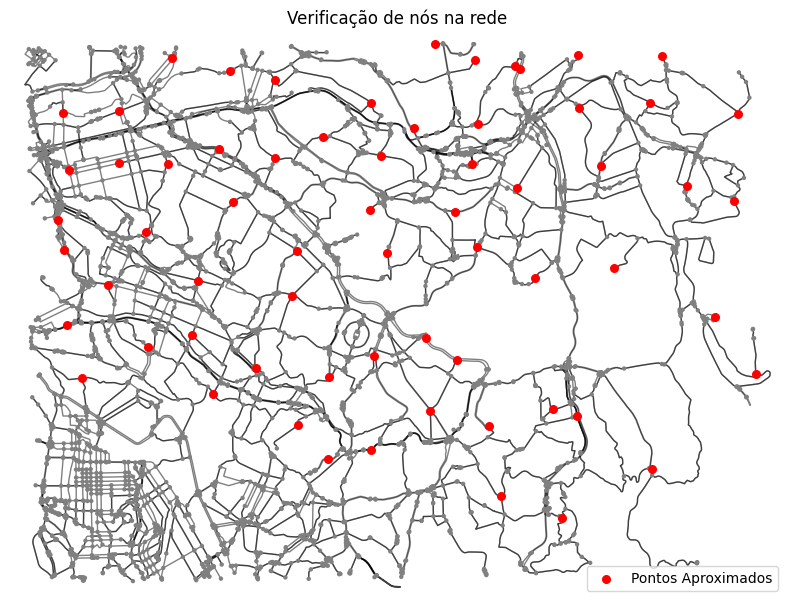

In [14]:
# 3. Visualizar os pontos e a rede
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotar a rede de ruas
ox.plot_graph(G_baseline_utm, ax=ax, node_color='gray', node_size=10, edge_color='black', edge_alpha=0.5, show=False, close=False)

# Plotar os pontos aproximados
gdf_nos_aproximados.plot(ax=ax, color='red', markersize=30, label="Pontos Aproximados")

plt.legend()
plt.title("Verificação de nós na rede")
plt.show()


#### Funções de apoio

In [15]:
def adjust_speed_batch(row, raster_data, transform, threshold, threshold_max, speed_column):
    """
    Ajusta a velocidade de um segmento com base na profundidade do alagamento extraída de um raster.

    Parâmetros:
        row (GeoSeries): Linha atual do GeoDataFrame contendo informações de velocidade e geometria.
        raster_data (numpy.ndarray): Dados do raster contendo profundidade de alagamento.
        transform (Affine): Transformação do raster para coordenadas espaciais.
        threshold (float): Profundidade mínima para ajustar a velocidade.
        threshold_max (float): Profundidade máxima que torna a via intransitável.
        speed_column (str): Nome da coluna de referência para a velocidade original.
    
    Retorno:
        float: Velocidade ajustada para o segmento.
    """

    # Encontrar a coordenada do centro do segmento
    centroid = row.geometry.centroid

    # Transformar as coordenadas do centroide em índices do raster
    try:
        col_idx, row_idx = ~transform * (centroid.x, centroid.y) # Observe a ordem inversa
        row_idx, col_idx = int(row_idx), int(col_idx)
    except Exception:
        # Caso algo dê errado na transformação, manter a velocidade original
        #print('Mantive a velocidade que veio!')
        return row[speed_column]

    # Verificar se os índices estão dentro dos limites do raster
    if not (0 <= row_idx < raster_data.shape[0] and 0 <= col_idx < raster_data.shape[1]):
        print(row_idx, raster_data.shape[0], col_idx, raster_data.shape[1])
        return row[speed_column]
    
    # Extração do valor de profundidade do raster
    flood_depth = 1000*raster_data[row_idx, col_idx] # Valor extraído do raster em metros
    #print(flood_depth)

    # Ajustar a velocidade com base na profundidade
    if flood_depth > threshold_max:
        # Caso a altura exceda o limiar máximo, torna-se instransitável
        return 0
    elif flood_depth > threshold:
        # Aplicar a fórmula de ajuste da velocidade
        adjusted_speed = 0.0009 * (flood_depth ** 2) - 0.5529 * flood_depth + 86.9448
        #print('Pregnolato!')
        return min(adjusted_speed, row[speed_column])  # Garantir que não ultrapasse a velocidade original
        
    # Caso contrário, manter a velocidade original
    return row[speed_column]

In [16]:
def listar_atributos_arestas(G):
    atributos = set()
    for _, _, dados in G.edges(data=True):
        atributos.update(dados.keys())
    return atributos

# 1. Função para obter o número de viagens da matriz OD
def get_number_of_trips(node1, node2, referencia, od_matrix):
    zone1 = centroides_dentro.loc[centroides_dentro[referencia] == node1, 'NumeroZona'].values[0]
    zone2 = centroides_dentro.loc[centroides_dentro[referencia] == node2, 'NumeroZona'].values[0]
    return od_matrix.loc[zone1, zone2]

# 2. Definição da função para encontrar o caminho mínimo
def caminho_minimo(G, source, target, weight):
    # Encontrar o caminho mais curto
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    path_cost = nx.path_weight(G, path, weight=weight)
    return path, path_cost

def tempo_medio_viagem(arquivo):

    # Filtrar os valores finitos para tempo com peso e num_viagens
    finite_mask_baseline = np.isfinite(arquivo['Tempo ponderado (min)'])
    finite_tempos_e_viagens_baseline = arquivo[finite_mask_baseline]

    # Calcular o número total de viagens sem valores infinitos
    total_trips_weighted = finite_tempos_e_viagens_baseline['Num_viagens'].sum()

    # Calcular o tempo total sem peso ignorando valores infinitos
    total_time_weighted = finite_tempos_e_viagens_baseline['Tempo ponderado (min)'].sum()

    # Calcular o tempo médio de viagem ponderado
    mean_time_weighted = total_time_weighted / total_trips_weighted

    # Exibir os resultados
    #print(f"Tempo médio de viagem com chuva e ponderado: {mean_time_weighted:.2f} minutos")

    return mean_time_weighted

In [17]:
def calcular_similitude(gdf):
    # Seleciona a coluna de referência
    referencia = gdf['speed_kph']
    
    # Filtra colunas que começam com "pct1_h_"
    colunas_pct = [col for col in gdf.columns if col.startswith("pct")]
    
    # Lista para armazenar os resultados
    resultados = []

    # Calcula a correlação de Pearson entre speed_kph e cada coluna pct1_h_
    for col in colunas_pct:
        correlacao = referencia.corr(gdf[col])
        resultados.append({"Coluna": col, "Correlacao": correlacao})

    # Retorna um DataFrame com os resultados
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados

In [18]:
def calcular_similitude_tt(gdf):
    referencia = gdf['tt_speed_kph'].replace(np.inf, np.nan)  # Substitui infinitos por NaN
    
    colunas_pct = [col for col in gdf.columns if col.startswith("tt_pct")]
    
    resultados = {
        col: referencia.corr(gdf[col].replace(np.inf, np.nan))  
        for col in colunas_pct if not gdf[col].replace(np.inf, np.nan).isna().all()
    }
    
    return pd.DataFrame(resultados.items(), columns=['Coluna', 'Correlacao'])

#### Produzir novas referências de velocidade

In [20]:
# Obter a lista de arquivos TIFF no diretório
arquivos_tif = [f for f in os.listdir(clipado_path) if f.endswith(".tif")]
total_arquivos = len(arquivos_tif)  # Total de arquivos a serem processados

# Função para extrair o número que aparece depois de "h_" ou "max_"
def extrair_numero(nome):
    match = re.search(r'(?:h_|max_)(\d+)', nome)  # Captura o número após "h_" ou "max_"
    return int(match.group(1)) if match else float('inf')  # Retorna um número grande se não encontrar nada

# Ordenar a lista com base no número extraído
arquivos_ordenados = sorted(arquivos_tif, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in arquivos_ordenados:
    print(arquivo)

pct1_h_2692800_clp.tif
pct1_h_2696400_clp.tif
pct1_h_2700000_clp.tif
pct1_h_2703600_clp.tif
pct1_h_2707200_clp.tif
pct1_h_2710800_clp.tif
pct1_h_2714400_clp.tif
pct1_h_2718000_clp.tif
pct1_h_2721600_clp.tif
pct1_h_2725200_clp.tif
pct1_h_2728800_clp.tif
pct1_h_2732400_clp.tif
pct1_h_2736000_clp.tif
pct1_h_2739600_clp.tif
pct1_h_2743200_clp.tif
pct1_h_2746800_clp.tif
pct1_h_2750400_clp.tif
pct1_h_2754000_clp.tif
pct1_h_2757600_clp.tif
pct1_h_2761200_clp.tif
pct1_h_2764800_clp.tif
pct1_h_2768400_clp.tif
pct1_h_max_2768400_clp.tif


In [21]:
# Verificar que as colunas não estão presentes no GDF
edges_baseline_reprojected.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 8333 entries, (np.int64(597447), np.int64(25778775), np.int64(0)) to (np.int64(12013065742), np.int64(1269523805), np.int64(0))
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   osmid      8333 non-null   object  
 1   oneway     8333 non-null   bool    
 2   lanes      7167 non-null   object  
 3   ref        203 non-null    object  
 4   name       7047 non-null   object  
 5   highway    8333 non-null   object  
 6   maxspeed   2906 non-null   object  
 7   reversed   8333 non-null   object  
 8   length     8333 non-null   float64 
 9   geometry   8333 non-null   geometry
 10  speed_kph  8333 non-null   float64 
 11  bridge     270 non-null    object  
 12  access     37 non-null     object  
 13  tunnel     12 non-null     object  
 14  junction   263 non-null    object  
 15  est_width  38 non-null     object  
 16  width      13 non-null     object  
dt

In [22]:
# Iterar sobre os arquivos clipados
for index, filename in enumerate(arquivos_ordenados, start=1):  # Começa em 1
    print(f"\nProcessando arquivo {index} de {total_arquivos}: {filename}")

    # Extrair informações do nome do arquivo
    match = re.search(r'pct(?P<pct>\d+)_h(?:_max)?_(?P<value>\d+)_clp', filename)
    if match:
        pct = match.group('pct')  # Valor após "pct"
        value = match.group('value')  # Valor numérico
        is_max = '_max' in filename  # Verificar se "max" está presente

        # Criar o nome da coluna dinamicamente
        column_suffix = f"pct{pct}_h_{value}" + ("_max" if is_max else "")
        column_name = column_suffix  # Exemplo: "pct1_h_2692800" ou "pct1_h_max_2768400"
        #print(f"Coluna gerada: {column_name}")

        # Caminho completo do arquivo raster
        raster_path = os.path.join(clipado_path, filename)

        # Abrir o raster e extrair os dados
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)  # Ler a primeira banda do raster
            raster_transform = src.transform

        # Aplicar a função de ajuste e criar uma nova coluna
        edges_baseline_reprojected[column_name] = edges_baseline_reprojected.apply(
            adjust_speed_batch,
            axis=1,
            args=(raster_data, raster_transform, threshold, threshold_max, 'speed_kph')
        )

print("\nProcessamento concluído!\n")


Processando arquivo 1 de 23: pct1_h_2692800_clp.tif

Processando arquivo 2 de 23: pct1_h_2696400_clp.tif

Processando arquivo 3 de 23: pct1_h_2700000_clp.tif

Processando arquivo 4 de 23: pct1_h_2703600_clp.tif

Processando arquivo 5 de 23: pct1_h_2707200_clp.tif

Processando arquivo 6 de 23: pct1_h_2710800_clp.tif

Processando arquivo 7 de 23: pct1_h_2714400_clp.tif

Processando arquivo 8 de 23: pct1_h_2718000_clp.tif

Processando arquivo 9 de 23: pct1_h_2721600_clp.tif

Processando arquivo 10 de 23: pct1_h_2725200_clp.tif

Processando arquivo 11 de 23: pct1_h_2728800_clp.tif

Processando arquivo 12 de 23: pct1_h_2732400_clp.tif

Processando arquivo 13 de 23: pct1_h_2736000_clp.tif

Processando arquivo 14 de 23: pct1_h_2739600_clp.tif

Processando arquivo 15 de 23: pct1_h_2743200_clp.tif

Processando arquivo 16 de 23: pct1_h_2746800_clp.tif

Processando arquivo 17 de 23: pct1_h_2750400_clp.tif

Processando arquivo 18 de 23: pct1_h_2754000_clp.tif

Processando arquivo 19 de 23: pct1_h

In [23]:
# Verifique se as novas colunas foram adicionadas:
print(edges_baseline_reprojected.columns)

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'access',
       'tunnel', 'junction', 'est_width', 'width', 'pct1_h_2692800',
       'pct1_h_2696400', 'pct1_h_2700000', 'pct1_h_2703600', 'pct1_h_2707200',
       'pct1_h_2710800', 'pct1_h_2714400', 'pct1_h_2718000', 'pct1_h_2721600',
       'pct1_h_2725200', 'pct1_h_2728800', 'pct1_h_2732400', 'pct1_h_2736000',
       'pct1_h_2739600', 'pct1_h_2743200', 'pct1_h_2746800', 'pct1_h_2750400',
       'pct1_h_2754000', 'pct1_h_2757600', 'pct1_h_2761200', 'pct1_h_2764800',
       'pct1_h_2768400', 'pct1_h_2768400_max'],
      dtype='object')


In [24]:
df_resultados = calcular_similitude(edges_baseline_reprojected)

# Exibir os resultados ordenados por correlação
df_resultados.sort_values(by="Correlacao", ascending=False, inplace=True)
print(df_resultados)

                Coluna  Correlacao
0       pct1_h_2692800    1.000000
1       pct1_h_2696400    0.523518
2       pct1_h_2700000    0.464167
3       pct1_h_2703600    0.429037
4       pct1_h_2707200    0.422957
5       pct1_h_2710800    0.420643
6       pct1_h_2714400    0.418072
7       pct1_h_2718000    0.414637
8       pct1_h_2721600    0.408191
9       pct1_h_2725200    0.395990
10      pct1_h_2728800    0.379966
11      pct1_h_2732400    0.369152
12      pct1_h_2736000    0.365682
13      pct1_h_2739600    0.363256
21      pct1_h_2768400    0.361643
20      pct1_h_2764800    0.357838
14      pct1_h_2743200    0.356718
17      pct1_h_2754000    0.355269
19      pct1_h_2761200    0.355168
18      pct1_h_2757600    0.354036
16      pct1_h_2750400    0.353921
15      pct1_h_2746800    0.353055
22  pct1_h_2768400_max    0.345351


#### Calcular os tempos de viagem

In [25]:
def add_edge_travel_times_gdf2(gdf, referencia):
    referencia_corrigida = referencia.replace('_clp.tif', '')  
    nome = 'tt_' + referencia_corrigida   
    
    # Criar a coluna apenas se não existir
    if nome not in gdf.columns:
        gdf[nome] = np.nan  

    # Garantir que as colunas existam e preencher valores NaN com 0
    if referencia_corrigida not in gdf.columns:
        gdf[referencia_corrigida] = 0  # Evita KeyError

    gdf['length'] = gdf.get('length', 0).fillna(0)

    # Criar máscara para vias intransitáveis
    intransitavel_mask = gdf[referencia_corrigida] == 0

    # Atribuir valores de tempo de viagem
    gdf.loc[intransitavel_mask, nome] = np.inf
    gdf.loc[~intransitavel_mask, nome] = (gdf.loc[~intransitavel_mask, 'length'] * 3.6) / gdf.loc[~intransitavel_mask, referencia_corrigida]

    return gdf


In [26]:
# Aplicando a função para adicionar o tempo de viagem
data_batch = []
data = 0

for column_name in arquivos_ordenados:
    edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, column_name)
    data_batch.append({
                    'index': data + 1,
                    'Referência': column_name.replace('_clp.tif', ''), # Remove "_clp.tif" da referência.
                })
    data += 1

edges_simulados = add_edge_travel_times_gdf2(edges_baseline_reprojected, 'speed_kph') # Essa linha é necessária para construir o baseline no arquivo GDF
data_batch.append({
    'index': data,
    'Referência': 'speed_kph',
})

# Criar DataFrame com os resultados
detalhes_arquivo_df = pd.DataFrame(data_batch)

# Criando a coluna "Max" com valor 0 por padrão
detalhes_arquivo_df["Max"] = 0

# Encontrar a linha que contém "max_"
linha_max = detalhes_arquivo_df[detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

if not linha_max.empty:
    # Extrair o número após "max_"
    match = re.search(r"max_(\d+)", linha_max["Referência"].values[0])
    
    if match:
        numero_max = match.group(1)  # Captura apenas o número após "max_"
        
        # Atualizar a linha correspondente ao número extraído, definindo "Max" como 1
        detalhes_arquivo_df.loc[detalhes_arquivo_df["Referência"].str.contains(f"h_{numero_max}", na=False), "Max"] = 1

# Remover a linha que contém "max_"
detalhes_arquivo_df = detalhes_arquivo_df[~detalhes_arquivo_df["Referência"].str.contains("max_", na=False)]

# Resetar o índice para manter organizado
detalhes_arquivo_df.reset_index(drop=True, inplace=True)

# Exibir o DataFrame atualizado
print(detalhes_arquivo_df)

    index      Referência  Max
0       1  pct1_h_2692800    0
1       2  pct1_h_2696400    0
2       3  pct1_h_2700000    0
3       4  pct1_h_2703600    0
4       5  pct1_h_2707200    0
5       6  pct1_h_2710800    0
6       7  pct1_h_2714400    0
7       8  pct1_h_2718000    0
8       9  pct1_h_2721600    0
9      10  pct1_h_2725200    0
10     11  pct1_h_2728800    0
11     12  pct1_h_2732400    0
12     13  pct1_h_2736000    0
13     14  pct1_h_2739600    0
14     15  pct1_h_2743200    0
15     16  pct1_h_2746800    0
16     17  pct1_h_2750400    0
17     18  pct1_h_2754000    0
18     19  pct1_h_2757600    0
19     20  pct1_h_2761200    0
20     21  pct1_h_2764800    0
21     22  pct1_h_2768400    1
22     23       speed_kph    0


In [27]:
# Verifique se as novas colunas foram adicionadas:
print(edges_simulados.columns)

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'geometry', 'speed_kph', 'bridge', 'access',
       'tunnel', 'junction', 'est_width', 'width', 'pct1_h_2692800',
       'pct1_h_2696400', 'pct1_h_2700000', 'pct1_h_2703600', 'pct1_h_2707200',
       'pct1_h_2710800', 'pct1_h_2714400', 'pct1_h_2718000', 'pct1_h_2721600',
       'pct1_h_2725200', 'pct1_h_2728800', 'pct1_h_2732400', 'pct1_h_2736000',
       'pct1_h_2739600', 'pct1_h_2743200', 'pct1_h_2746800', 'pct1_h_2750400',
       'pct1_h_2754000', 'pct1_h_2757600', 'pct1_h_2761200', 'pct1_h_2764800',
       'pct1_h_2768400', 'pct1_h_2768400_max', 'tt_pct1_h_2692800',
       'tt_pct1_h_2696400', 'tt_pct1_h_2700000', 'tt_pct1_h_2703600',
       'tt_pct1_h_2707200', 'tt_pct1_h_2710800', 'tt_pct1_h_2714400',
       'tt_pct1_h_2718000', 'tt_pct1_h_2721600', 'tt_pct1_h_2725200',
       'tt_pct1_h_2728800', 'tt_pct1_h_2732400', 'tt_pct1_h_2736000',
       'tt_pct1_h_2739600', 'tt_pct1_h_27

In [28]:
df_resultados_tt = calcular_similitude_tt(edges_simulados)

# Exibir os resultados ordenados por Coluna
df_resultados_tt.sort_values(by="Coluna", ascending=True, inplace=True)
print(df_resultados_tt)

               Coluna  Correlacao
0   tt_pct1_h_2692800    1.000000
1   tt_pct1_h_2696400    0.672331
2   tt_pct1_h_2700000    0.721648
3   tt_pct1_h_2703600    0.578491
4   tt_pct1_h_2707200    0.454230
5   tt_pct1_h_2710800    0.426059
6   tt_pct1_h_2714400    0.390867
7   tt_pct1_h_2718000    0.683948
8   tt_pct1_h_2721600    0.688925
9   tt_pct1_h_2725200    0.704728
10  tt_pct1_h_2728800    0.641993
11  tt_pct1_h_2732400    0.731403
12  tt_pct1_h_2736000    0.702887
13  tt_pct1_h_2739600    0.683351
14  tt_pct1_h_2743200    0.646108
15  tt_pct1_h_2746800    0.660399
16  tt_pct1_h_2750400    0.588471
17  tt_pct1_h_2754000    0.704490
18  tt_pct1_h_2757600    0.676235
19  tt_pct1_h_2761200    0.616031
20  tt_pct1_h_2764800    0.637502
21  tt_pct1_h_2768400    0.659127


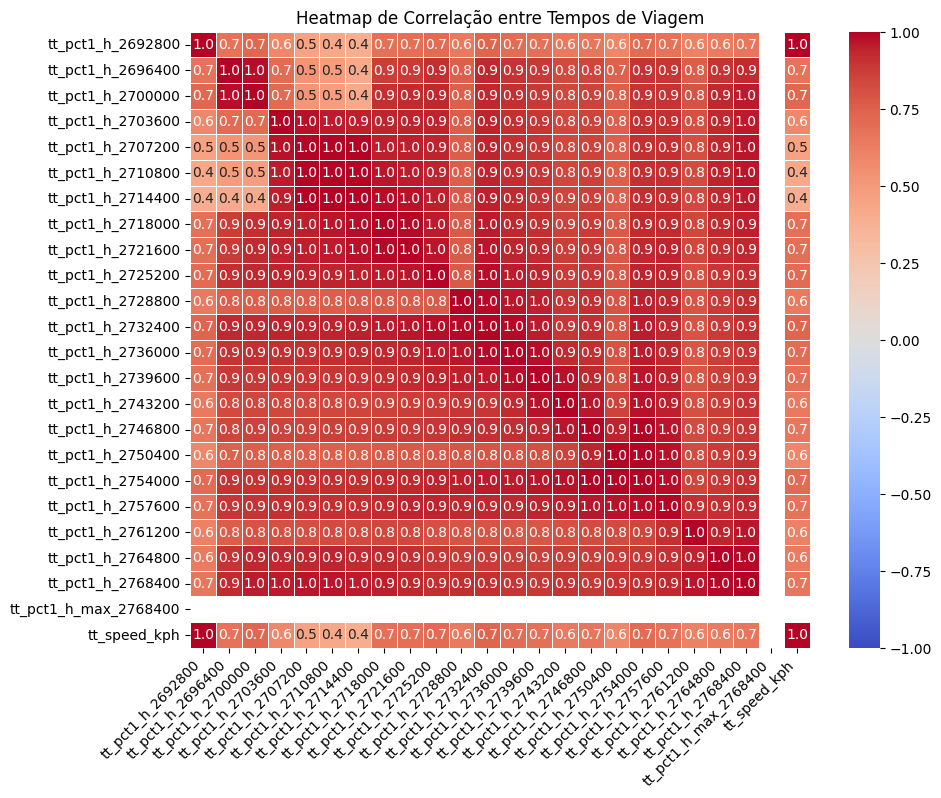

In [31]:
def plot_heatmap_correlacao_tt(gdf):
    # Selecionar apenas as colunas que começam com "tt_"
    colunas_tt = [col for col in gdf.columns if col.startswith("tt_")]
    
    # Criar um DataFrame apenas com essas colunas e substituir infinitos por NaN
    df_tt = gdf[colunas_tt].replace(np.inf, np.nan)
    
    # Calcular a matriz de correlação (ignora NaNs automaticamente)
    matriz_correlacao = df_tt.corr()
    
    # Criar o heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5, vmin=-1, vmax=1)
    
    # Ajustes no gráfico
    plt.title("Heatmap de Correlação entre Tempos de Viagem")
    plt.xticks(rotation=45, ha="right")  # Rotaciona os rótulos para melhor visualização
    plt.yticks(rotation=0)
    plt.show()

# Chamar a função passando o GeoDataFrame (gdf)
plot_heatmap_correlacao_tt(edges_simulados)


#### Construir um novo grafo, com todas referências de velocidades

MultiDiGraph with 4453 nodes and 8333 edges


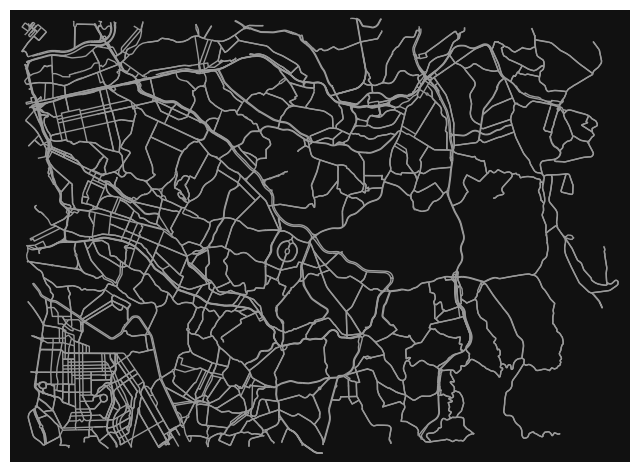

O sistema de referência de coordenadas do G_dinamico é: EPSG:31983


In [32]:
# Garantir que os nós tenham colunas 'x' e 'y' extraídas da geometria
#node_baseline["x"] = node_baseline.geometry.x
#node_baseline["y"] = node_baseline.geometry.y

# Gerar o grafo e armazená-lo no dicionário
G_dinamico = ox.graph_from_gdfs(node_baseline, edges_simulados)

# Exibir o grafo
print(G_dinamico)
ox.plot_graph(G_dinamico)

# Verificar o sistema de referência de coordenadas
crs = G_dinamico.graph['crs']
print(f'O sistema de referência de coordenadas do G_dinamico é:', crs)

In [33]:
listar_atributos_arestas(G_dinamico)

{'access',
 'bridge',
 'est_width',
 'geometry',
 'highway',
 'junction',
 'lanes',
 'length',
 'maxspeed',
 'name',
 'oneway',
 'osmid',
 'pct1_h_2692800',
 'pct1_h_2696400',
 'pct1_h_2700000',
 'pct1_h_2703600',
 'pct1_h_2707200',
 'pct1_h_2710800',
 'pct1_h_2714400',
 'pct1_h_2718000',
 'pct1_h_2721600',
 'pct1_h_2725200',
 'pct1_h_2728800',
 'pct1_h_2732400',
 'pct1_h_2736000',
 'pct1_h_2739600',
 'pct1_h_2743200',
 'pct1_h_2746800',
 'pct1_h_2750400',
 'pct1_h_2754000',
 'pct1_h_2757600',
 'pct1_h_2761200',
 'pct1_h_2764800',
 'pct1_h_2768400',
 'pct1_h_2768400_max',
 'pct1_h_max_2768400',
 'ref',
 'reversed',
 'speed_kph',
 'tt_pct1_h_2692800',
 'tt_pct1_h_2696400',
 'tt_pct1_h_2700000',
 'tt_pct1_h_2703600',
 'tt_pct1_h_2707200',
 'tt_pct1_h_2710800',
 'tt_pct1_h_2714400',
 'tt_pct1_h_2718000',
 'tt_pct1_h_2721600',
 'tt_pct1_h_2725200',
 'tt_pct1_h_2728800',
 'tt_pct1_h_2732400',
 'tt_pct1_h_2736000',
 'tt_pct1_h_2739600',
 'tt_pct1_h_2743200',
 'tt_pct1_h_2746800',
 'tt_pct1_h

In [34]:
# Verificar que os valores infinitos foram devidamente convertidos

# Nome da coluna de teste. Escolhi a max
coluna_alvo = "tt_pct1_h_2768400"

# Obter todas as arestas com seus atributos
dados_arestas = [data.get(coluna_alvo, np.nan) for _, _, data in G_dinamico.edges(data=True)]

# Contar quantos valores são infinitos
num_infinitos = np.isinf(dados_arestas).sum()

print(f"Número de valores infinitos em '{coluna_alvo}': {num_infinitos}")

Número de valores infinitos em 'tt_pct1_h_2768400': 653


#### Cálculo do caminho mínimo

In [66]:
def caminho_minimo(G, origem, destino, referencia):
    """
    Calcula o caminho mínimo entre dois nós no grafo OSMnx, considerando apenas arestas transitáveis.

    Parâmetros:
        G: networkx.MultiDiGraph - Grafo de ruas OSMnx.
        origem: int - ID do nó de origem.
        destino: int - ID do nó de destino.
        referencia: str - Nome da referência usada para tempo de viagem (ex.: 'pct1_h_2707200').

    Retorna:
        caminho: list - Lista de nós que formam o caminho mínimo.
        distancia: float - Distância total do caminho.
    """
    if not nx.is_directed(G):
        print("⚠️ O grafo fornecido não é direcionado.")
        return None, None

    if not nx.has_path(G, origem, destino):
        print(f'⚠️ Não há caminho transitável entre os pontos: {origem} e {destino}')
        return None, None

    # Criar uma cópia filtrando arestas inválidas
    G_filtrado = G.copy()
    edges_remover = [(u, v, k) for u, v, k, d in G.edges(keys=True, data=True) if d.get(referencia, float('inf')) == float('inf')]
    G_filtrado.remove_edges_from(edges_remover)

    # Verificar se o grafo ainda possui um caminho válido após remoção de arestas
    if not nx.has_path(G_filtrado, origem, destino):
        print(f'⚠️ Não há caminho transitável após filtragem das arestas inválidas.')
        return None, None

    # Definir o peso com prioridade na referência, senão usar distância ("length")
    peso = referencia if any(referencia in d for _, _, d in G_filtrado.edges(data=True)) else "length"

    # Calcular o caminho mínimo
    caminho = nx.shortest_path(G_filtrado, source=origem, target=destino, weight=peso)
    distancia = nx.shortest_path_length(G_filtrado, source=origem, target=destino, weight=peso)

    return caminho, distancia

In [71]:
centroides_dentro.head()

,NumeroZona,NomeZona,geometry,nearest_node_baseline,node_x,node_y
0,46,Água Rasa,POINT (340287.038 7392203.025),340185206,340345.072231,7.392089e+06
1,47,Vila Bertioga,POINT (338881.873 7392840.545),4499663530,339182.856661,7.393006e+06
2,48,Regente Feijó,POINT (339150.693 7393849.66),458457689,339013.386236,7.393813e+06
3,166,Gomes Cardim,POINT (340580.324 7395170.267),129958225,340644.108037,7.395320e+06
4,167,Tatuapé,POINT (339357.583 7395121.302),130009969,339317.524616,7.395140e+06


In [72]:
gdf_nos_aproximados.head()

,NumeroZona,NomeZona,geometry,nearest_node_baseline,node_x,node_y,distance_to_nearest_node
0,46,Água Rasa,POINT (340345.072 7392089.156),340185206,340345.072231,7.392089e+06,0.0
1,47,Vila Bertioga,POINT (339182.857 7393006.426),4499663530,339182.856661,7.393006e+06,0.0
2,48,Regente Feijó,POINT (339013.386 7393812.703),458457689,339013.386236,7.393813e+06,0.0
3,166,Gomes Cardim,POINT (340644.108 7395320.352),129958225,340644.108037,7.395320e+06,0.0
4,167,Tatuapé,POINT (339317.525 7395140.345),130009969,339317.524616,7.395140e+06,0.0


In [36]:
def calcula_caminho_minimo(gdf_OD, referencia_OD, G, referencia, revalida=False, sem_caminho=None):
    """
    Calcula caminhos mínimos entre pares de nós em um grafo OSMnx, considerando apenas vias transitáveis.

    Parâmetros:
        gdf_OD: GeoDataFrame - Contém os nós de origem e destino.
        referencia_OD: str - Nome da coluna no gdf_OD com os IDs dos nós.
        G: networkx.MultiDiGraph - Grafo de ruas OSMnx.
        referencia: str - Nome da referência usada para tempo de viagem.
        revalida: bool - Se True, ignora pares já conhecidos sem caminho.
        sem_caminho: set - Conjunto de pares (origem, destino) sem caminho (para revalidação).

    Retorna:
        tempos_e_viagens_arquivo: DataFrame - Resultados das viagens calculadas.
        sem_caminho: set - Atualização dos pares sem caminho.
    """

    if sem_caminho is None:
        sem_caminho = set()

    data_batch = []
    start_time = time.time()
    
    if revalida:
        print(f'Modo revalidação ativado. Ignorando {len(sem_caminho)} pares sem caminho.')

    # Itera sobre todas as combinações de pares de nós
    for node1, node2 in itertools.combinations(gdf_OD[referencia_OD], 2):
        if node1 == node2 or (revalida and (node1, node2) in sem_caminho):
            continue  # Ignorar nós idênticos ou já marcados como sem caminho

        if node1 in G.nodes and node2 in G.nodes:
            try:
                # Obter o número de viagens entre os nós
                num_trips = get_number_of_trips(node1, node2, referencia_OD, matriz_od_25)
                if num_trips > 0:
                    # Usar a função otimizada para calcular o caminho mínimo
                    caminho, tempo = caminho_minimo(G, node1, node2, referencia)

                    if caminho is not None:  # Garantir que existe um caminho
                        weighted_time_rain = tempo * num_trips
                        data_batch.append({
                            'Referência': referencia,
                            'Origem': node1,
                            'Destino': node2,
                            'Num_viagens': num_trips,
                            'Tempo de viagem (min)': tempo / 60,
                            'Número de nós': len(caminho),
                            'Percurso entre nós': list(caminho),
                            'Tempo ponderado (min)': weighted_time_rain / 60
                        })
                    else:
                        sem_caminho.add((node1, node2))  # Registrar nós sem caminho
            except nx.NetworkXNoPath:
                sem_caminho.add((node1, node2))
        else:
            print(f"⚠️ Nó(s) {node1} ou {node2} não encontrado(s) no grafo.")

    # Calcular tempo de processamento
    processing_time = time.time() - start_time
    print(f"Tempo de processamento: {processing_time:.2f} segundos")
    print(f'Foram calculadas {len(data_batch)} viagens')
    print('Total de viagens sem conexão:', len(sem_caminho))

    return pd.DataFrame(data_batch), sem_caminho

In [69]:
atributos_tt = set()
    
for _, _, dados in G_dinamico.edges(data=True):
    for atributo in dados.keys():
        if atributo.startswith("tt"):
            atributos_tt.add(atributo)

atributos_tt = [linha for linha in atributos_tt if "speed"not in linha]

#Ordenar a lista pelo número extraído
atributos_tt_ord = sorted(atributos_tt, key=extrair_numero)

# Exibir a lista ordenada
for arquivo in atributos_tt_ord:
    print(arquivo)

# Limitando o tamanho da lista para facilitar o debug
atributos_tt_ord = atributos_tt_ord[4:5]
print(atributos_tt_ord)

tt_pct1_h_2692800
tt_pct1_h_2696400
tt_pct1_h_2700000
tt_pct1_h_2703600
tt_pct1_h_2707200
tt_pct1_h_2710800
tt_pct1_h_2714400
tt_pct1_h_2718000
tt_pct1_h_2721600
tt_pct1_h_2725200
tt_pct1_h_2728800
tt_pct1_h_2732400
tt_pct1_h_2736000
tt_pct1_h_2739600
tt_pct1_h_2743200
tt_pct1_h_2746800
tt_pct1_h_2750400
tt_pct1_h_2754000
tt_pct1_h_2757600
tt_pct1_h_2761200
tt_pct1_h_2764800
tt_pct1_h_2768400
tt_pct1_h_max_2768400
['tt_pct1_h_2707200']


In [82]:
data = 0
data_batch = []

for coluna in atributos_tt_ord:
    print(coluna)
    sem_caminho2 = []
    tempos_e_viagens_chuva_domimgo2 = []
    sem_caminho = set()

    # 1o Cálculo do caminho mínimo, sem chuva
    #tempos_e_viagens_domingo, sem_caminho = calcula_caminho_minimo(gdf_nos_aproximados,'nearest_node_baseline', G_dinamico, 'tt_speed_kph')
    #if not tempos_e_viagens_domingo.empty:
    #    tt_seco = tempo_medio_viagem(tempos_e_viagens_domingo)
    #    print(tt_seco)

    # 2o Cálculo do caminho mínimo, com chuva
    tempos_e_viagens_domingo2, sem_caminho2 = calcula_caminho_minimo(gdf_nos_aproximados,'nearest_node_baseline', G_dinamico, coluna)
    if not tempos_e_viagens_domingo2.empty:
        tt_chuva = tempo_medio_viagem(tempos_e_viagens_domingo2)
        print(tt_chuva)    

tt_pct1_h_2707200
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 458457689 e 8699569461
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 129958225 e 8699569461
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 130009969 e 8699569461
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 8773249082 e 8699569461
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 433999406 e 8699569461
⚠️ Não há caminho transitável após filtragem das arestas inválidas.
⚠️ Não há caminho transitável entre os pontos: 2106532284 e 2583003908
⚠️ Não há caminh

In [65]:
nx.has_path(G_dinamico,458457689, 5334219098)

True

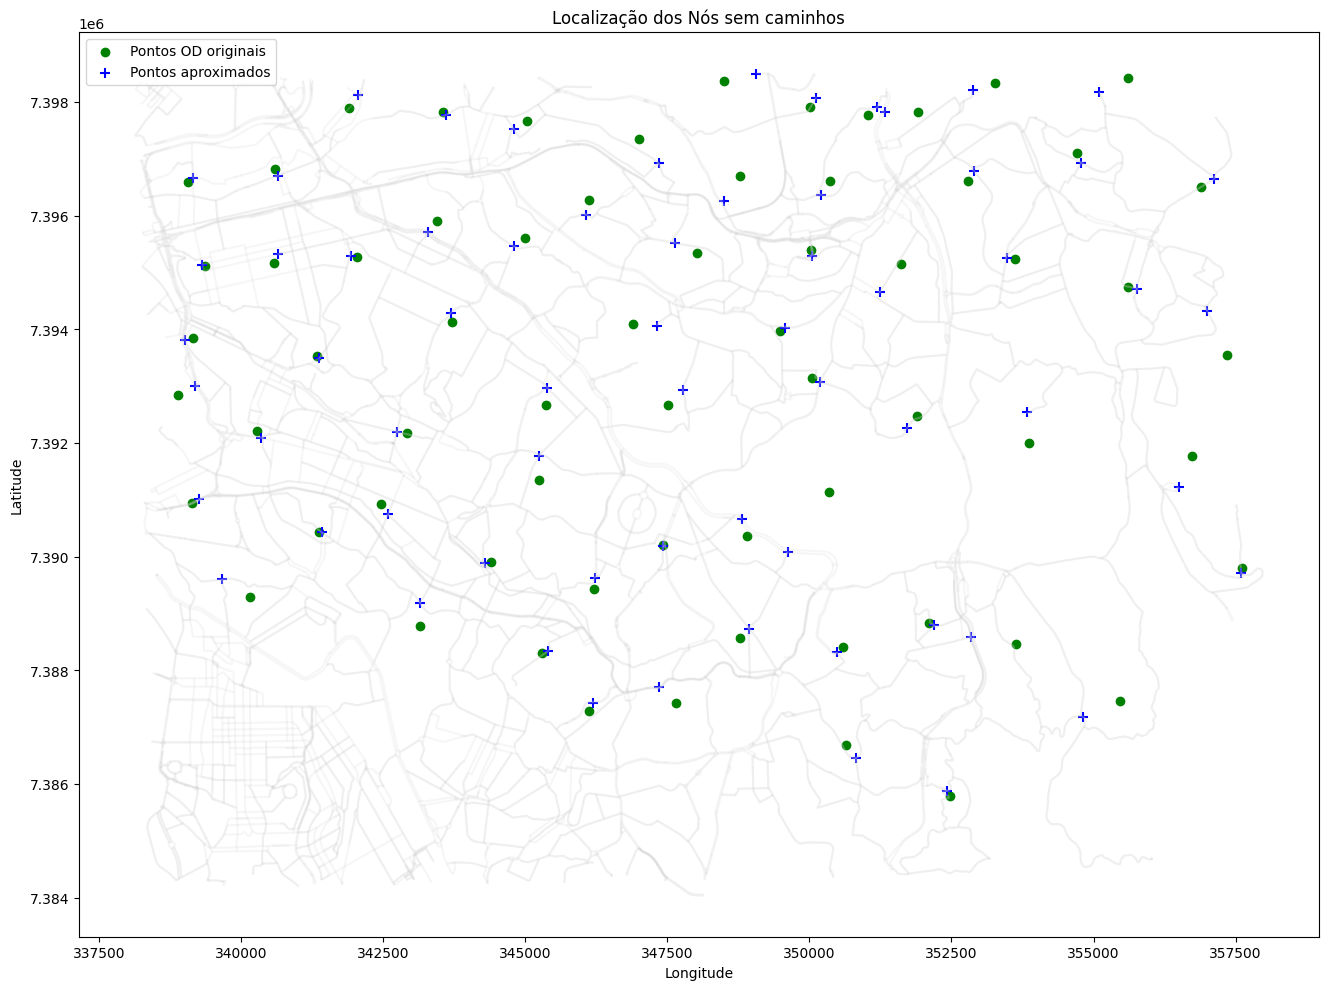

In [39]:
# Verificação gráfica do resultado
base2 = centroides_dentro.plot(color='green', figsize=(16,16), label='Pontos OD originais')

edges_baseline_reprojected.plot(ax=base2, color='lightgrey', alpha=0.2)

gdf_nos_aproximados.plot(ax=base2, marker='+', color='blue', markersize=50, label='Pontos aproximados')

plt.title('Localização dos Nós sem caminhos')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

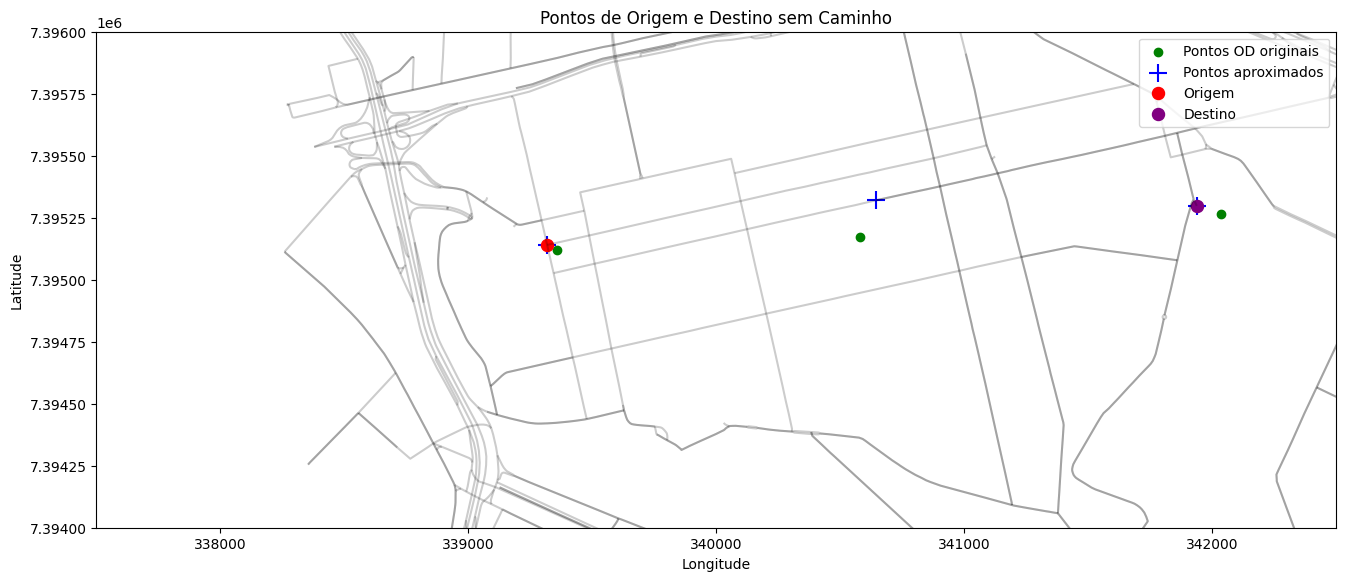

In [79]:
# Converter o set para uma lista para acessar um par específico
lista_sem_caminho = list(sem_caminho)

# Escolher um par específico (por exemplo, o primeiro)
origem, destino = lista_sem_caminho[25]

# Obter as coordenadas dos nós de origem e destino
ponto_origem = gdf_nos_aproximados[gdf_nos_aproximados["nearest_node_baseline"] == origem]
ponto_destino = gdf_nos_aproximados[gdf_nos_aproximados["nearest_node_baseline"] == destino]

# Verificação se os pontos foram encontrados
if not ponto_origem.empty and not ponto_destino.empty:
    base2 = centroides_dentro.plot(color='green', figsize=(16,16), label='Pontos OD originais')
    edges_baseline_reprojected.plot(ax=base2, color='black', alpha=0.2)
    gdf_nos_aproximados.plot(ax=base2, marker='+', color='blue', markersize=150, label='Pontos aproximados')

    # Plotar origem e destino
    ponto_origem.plot(ax=base2, marker='o', color='red', markersize=75, label='Origem')
    ponto_destino.plot(ax=base2, marker='o', color='purple', markersize=75, label='Destino')

    # Definir os limites do eixo X e Y (zoom manual)
    base2.set_xlim(337500, 342500)  # Ajuste do zoom no eixo X
    base2.set_ylim(7.394e6, 7.396e6)  # Ajuste do zoom no eixo Y

    plt.title('Pontos de Origem e Destino sem Caminho')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
else:
    print("Origem ou destino não encontrados no GeoDataFrame.")


In [81]:
len(sem_caminho

{(129958225, 8699569461),
 (130009969, 8699569461),
 (155371196, 1662593611),
 (242661092, 1662593611),
 (242661092, 2583003908),
 (242661092, 8699569461),
 (433999406, 8699569461),
 (458457689, 8699569461),
 (1422532772, 155371115),
 (1422532772, 1679523477),
 (1422532772, 1705054810),
 (1422532772, 2488906786),
 (1422532772, 3830604147),
 (1422532772, 8707027731),
 (1660722712, 1662593611),
 (1660722712, 8699569461),
 (1677334673, 8699569461),
 (1705054810, 8699569461),
 (2106532284, 1662593611),
 (2106532284, 2583003908),
 (2583003908, 1662593611),
 (2780533002, 2583003908),
 (2880970643, 1662593611),
 (3905134105, 1662593611),
 (5334219098, 1662593611),
 (5337689323, 1662593611),
 (5345831151, 1662593611),
 (8773249082, 8699569461)}

In [63]:
caminho, tempo = caminho_minimo(G_dinamico, origem, destino, 'speed_kph')

In [80]:
caminho = nx.shortest_path(G_dinamico, source=origem, target=destino, weight='tt_speed_kph')

NetworkXNoPath: No path between 130009969 and 8699569461.

In [49]:
gdf_nos_aproximados.explore()